In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import ujson, os

from scipy.stats import scoreatpercentile as scap

from cmdstanpy import set_cmdstan_path, CmdStanModel, from_csv
import arviz as az
import corner

from astropy.table import Table
import astropy.units as u
import astropy.constants as c
from astropy.coordinates import Galactocentric, ICRS, CartesianDifferential
au_km_year_per_sec = (c.au / (1*u.yr).to(u.s)).to(u.km/u.s).value

from plotstyles import useagab, apply_tufte
from robuststats import rse

from diskkinematicmodel import *
from icrstogal import *
from loadmwsamples import *

useagab()

select fgkm.*, gaia.ra, gaia.dec, gaia.parallax, gaia.pmra, gaia.pmdec, 
gaia.pmra_error, gaia.pmdec_error, gaia.parallax_error,
gaia.pmra_pmdec_corr, gaia.parallax_pmra_corr, gaia.parallax_pmdec_corr,
gaia.radial_velocity, gaia.radial_velocity_error, gaia.rv_template_teff, gaia.grvs_mag,
gaia.phot_g_mean_mag, gaia.bp_rp, gaia.bp_g, gaia.g_rp, ap.abp_gspphot, ap.arp_gspphot
from gaiadr3.gaia_source as gaia
join gaiadr3.gold_sample_fgkm_stars as fgkm
using (source_id)
join gaiadr3.astrophysical_parameters as ap
using (source_id)

In [2]:
Rsun = 8277.0*u.pc

fgkmtable = load_mwtable('./data/FGKMGoldenSample.fits', Rsun=Rsun, esphs=False)

Number of stars in selected sample: 23789


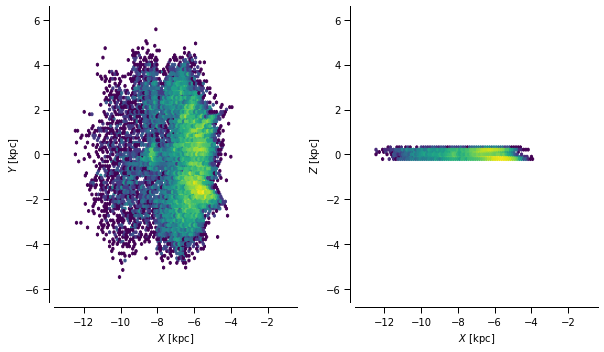

In [3]:
plx_snrlim = 10
vtanhalo = 180.0

plxfilter = fgkmtable['parallax_over_error']>plx_snrlim
zmax = 250

sample_filter_init = plxfilter & (np.abs(np.sin(np.deg2rad(fgkmtable['b']))*1000/fgkmtable['parallax']) < zmax)

R_filter = (fgkmtable['R_gc']>6500.0) & (fgkmtable['R_gc']<15000.0)

no_spt_filter = fgkmtable['source_id'] > 0
giants = fgkmtable['logg_gspphot'] <= 3.0
fstars = (fgkmtable['logg_gspphot'] > 4.0 ) & (fgkmtable['teff_gspphot'] > 6000)
gstars = (fgkmtable['logg_gspphot'] > 4.0 ) & (fgkmtable['teff_gspphot'] <= 6000) & (fgkmtable['teff_gspphot'] > 5000)
kstars = (fgkmtable['logg_gspphot'] > 4.0 ) & (fgkmtable['teff_gspphot'] <= 5000) & (fgkmtable['teff_gspphot'] > 4000)
mstars = (fgkmtable['logg_gspphot'] > 4.0 ) & (fgkmtable['teff_gspphot'] <= 4000)

# Choice of stars
spt_lum_filter = giants
fit_save_location = os.path.join(os.getcwd(), 'fitfiles/giants')

sample_filter = sample_filter_init & spt_lum_filter #& R_filter

print(f"Number of stars in selected sample: {fgkmtable['ra'][sample_filter].size}")

subsample_size = 300
if (fgkmtable['ra'][sample_filter].size <=subsample_size):
    fgkm_subsample = fgkmtable[sample_filter]
else:
    random_subsample = np.random.choice(np.arange(fgkmtable['ra'][sample_filter].size), size=subsample_size, replace=False)
    fgkm_subsample = fgkmtable[sample_filter][random_subsample]
    
plotgrid = [-13, -1, -6, 6]
fig=plt.figure(figsize=(8.5,5), tight_layout=True)

gs = fig.add_gridspec(1, 2, figure=fig)

ax_xy = fig.add_subplot(gs[0,0])
apply_tufte(ax_xy)
ax_xz = fig.add_subplot(gs[0,1])
apply_tufte(ax_xz)

ax_xy.hexbin(fgkmtable['x_gc'][sample_filter]/1000, fgkmtable['y_gc'][sample_filter]/1000, mincnt=1, bins='log', extent=plotgrid)
ax_xy.set_xlabel(r'$X$ [kpc]') 
ax_xy.set_ylabel(r'$Y$ [kpc]') 

ax_xz.hexbin(fgkmtable['x_gc'][sample_filter]/1000, fgkmtable['z_gc'][sample_filter]/1000, mincnt=1, bins='log', extent=plotgrid)
ax_xz.set_xlabel(r'$X$ [kpc]') 
ax_xz.set_ylabel(r'$Z$ [kpc]')

plt.show()

Median d*sin(b): -74.5
RSE d*sin(b): 160.5
Mean d*sin(b): -33.7


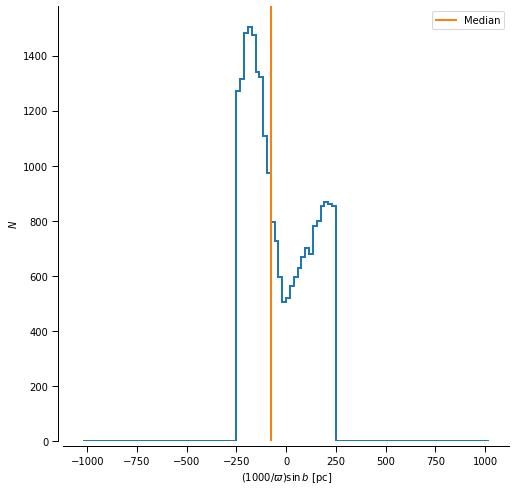

In [4]:
fig, axdsinb = plt.subplots(1, 1, figsize=(8,8))
apply_tufte(axdsinb)

dsinb = (np.sin(np.deg2rad(fgkmtable['b']))*1000.0/fgkmtable['parallax'])[sample_filter]
print(f"Median d*sin(b): {np.median(dsinb):.1f}")
print(f"RSE d*sin(b): {rse(dsinb):.1f}")
print(f"Mean d*sin(b): {dsinb.mean():.1f}")
zsun = 0.0*u.pc #-np.median(dsinb)*u.pc

axdsinb.hist(dsinb, bins='auto', histtype='step', lw=2, range=[-1020,1020])
axdsinb.axvline(x=np.median(dsinb), color='C1', label='Median')
axdsinb.set_xlabel(r'$(1000/\varpi)\sin b$ [pc]')
axdsinb.set_ylabel(r'$N$')
axdsinb.legend()

plt.show()

In [6]:
nsources = fgkm_subsample['ra'].size
print(f"Number of sources in sample: {nsources}")

fgkm_data = {'N': nsources, 
            'galon': np.deg2rad(fgkm_subsample['l']).tolist(), 
            'galat': np.deg2rad(fgkm_subsample['b']).tolist(),
            'pml_obs': fgkm_subsample['pml'].tolist(),
            'pml_obs_unc': fgkm_subsample['pml_error'].tolist(),
            'pmb_obs': fgkm_subsample['pmb'].tolist(),
            'pmb_obs_unc': fgkm_subsample['pmb_error'].tolist(),
            'pml_pmb_corr': fgkm_subsample['pml_pmb_corr'].tolist(),
            'plx_obs': fgkm_subsample['parallax'].tolist(),
            'Rsun': Rsun.value,
            'Zsun': zsun.value
            }
with open('fgkm.data.json', 'w') as fp: 
    ujson.dump(fgkm_data, fp)    # R: Converts python object to JSON data format
    fp.close()
    

base_bp_model = {'stanfile':'stanfiles/rotcurve-bp2_1.stan',
                'npars': 7,
                'parnames':['h_param', 'p_param', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'vdispxy', 'vdispz'],
                'labels':[r'h', r'p', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'$\sigma_{v,xy}$', r'$\sigma_{v,z}$'],
                'inits':{'h_param':3.0, 'p_param':-0.55, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'vdispxy':10.0, 'vdispz':10.0},
                'best_params':{'h_param':np.nan, 'p_param':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan, 'vdispxy':np.nan, 'vdispz':np.nan}
                }

improved_bp_model = {'stanfile':'stanfiles/rotcurve-bp2_2.stan',
                'npars': 8,
                'parnames':['h_param', 'p_param', 'v0', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'vdispxy', 'vdispz'],
                'labels':[r'h', r'p', 'V_0', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'$\sigma_{v,xy}$', r'$\sigma_{v,z}$'],
                'inits':{'h_param':3.0, 'p_param':-0.55, 'v0':234.0, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'vdispxy':10.0, 'vdispz':10.0},
                'best_params':{'h_param':np.nan, 'p_param':np.nan, 'v0':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan, 'vdispxy':np.nan, 'vdispz':np.nan}
                }

vdisp_function_bp_model = {'stanfile':'stanfiles/rotcurve-bp2_2_giants_std.stan',
                'npars': 8,
                'parnames':['h_param', 'p_param', 'v0', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'vdispxy_vector', 'vdispz'],
                'labels':[r'h', r'p', 'V_0', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'$\sigma_{v,xy}$', r'$\sigma_{v,z}$'],
                'inits':{'h_param':3.0, 'p_param':-0.55, 'v0':234.0, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'vdispxy':np.nan, 'vdispz':10.0},
                'best_params':{'h_param':np.nan, 'p_param':np.nan, 'v0':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan, 'vdispxy':np.nan, 'vdispz':np.nan}
                }

vdisp_function_bp2_3_model_nov0 = {'stanfile':'stanfiles/rotcurve-bp2_3_giants_std_nov0.stan',
                'npars': 11,
                'parnames':['h_param', 'p_param', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'amplitude_x', 'amplitude_y', 'amplitude_z', 'R_scale_x', 'R_scale_y', 'R_scale_z'],
                'labels':[r'h', r'p', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'A_X', r'A_Y', r'A_Z', r'R_{scale, x}', r'R_{scale, y}', r'R_{scale, z}'],
                'inits':{'h_param':3.0, 'p_param':-0.55, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'amplitude_x':80, 'amplitude_y':80, 'amplitude_z':80, 'R_scale_x':1, 'R_scale_y':1, 'R_scale_z':1},
                'best_params':{'h_param':np.nan, 'p_param':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan, 'amplitude_x':np.nan, 'amplitude_y':np.nan, 'amplitude_z':np.nan, 'R_scale_x':np.nan, 'R_scale_y':np.nan, 'R_scale_z':np.nan}
                }

vdisp_function_bp2_3_model_with_v0 = {'stanfile':'stanfiles/rotcurve-bp2_3_giants_std_with_v0.stan',
                'npars': 12,
                'parnames':['h_param', 'p_param', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'v0', 'amplitude_x', 'amplitude_y', 'amplitude_z', 'R_scale_x', 'R_scale_y', 'R_scale_z'],
                'labels':[r'h', r'p', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'v_0', r'A_X', r'A_Y', r'A_Z', r'R_{scale, x}', r'R_{scale, y}', r'R_{scale, z}'],
                'inits':{'h_param':3.0, 'p_param':-0.55, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'v0':234.0, 'amplitude_x':80, 'amplitude_y':80, 'amplitude_z':80, 'R_scale_x':1, 'R_scale_y':1, 'R_scale_z':1},
                'best_params':{'h_param':np.nan, 'p_param':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan, 'v0':np.nan, 'amplitude_x':np.nan, 'amplitude_y':np.nan, 'amplitude_z':np.nan, 'R_scale_x':np.nan, 'R_scale_y':np.nan, 'R_scale_z':np.nan}
                }



stan_model = vdisp_function_bp2_3_model_with_v0

Number of sources in sample: 300


In [16]:
print(len(stan_model['parnames']))
print(len(stan_model['best_params']))
print(len(stan_model['labels']))
print((stan_model['npars']))

12
12
12
12


In [39]:
# Reading in earlier produced fits
filter_dictionary = {
                  'no_spt_filter':no_spt_filter,
                  'giants':giants,
                  'fstars':fstars,
                  'gstars':gstars,
                  'kstars':kstars,
                  'mstars':mstars,
                 }
# Choice of stars
filter_of_choice = "giants"

spt_lum_filter = filter_dictionary[filter_of_choice]
fit_save_location = os.path.join(os.getcwd(), 'fitfiles', filter_of_choice)

fgkm_fit = from_csv(path=fit_save_location)
print(fit_save_location[-len(filter_of_choice):])

15:13:42 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 3 had 2 divergent transitions (0.2%)
	Chain 4 had 14 divergent transitions (1.4%)
	Use function "diagnose()" to see further information.
	Chain 3 had 2 divergent transitions (0.2%)
	Chain 4 had 14 divergent transitions (1.4%)
	Use function "diagnose()" to see further information.


giants


In [16]:
print("Chains:", fgkm_fit.chains)
temp = fgkm_fit[fgkm_fit.chain_ids != 1]
print("Chain_ids:", temp)
# print("Column names:", fgkm_fit.column_names)
print("Divergences:", fgkm_fit.divergences)

# temp.summary()[0:stan_model['npars']+6]

Chains: 4


TypeError: 'CmdStanMCMC' object is not subscriptable

In [42]:
draws = fgkm_fit.draws()
print(np.size(draws))
print("# draws:", len(draws[:,0,0]))
print("# chains:", len(draws[0,:,0]))
print("# columns:", len(draws[0,0,:]))
print(np.size(draws[:,1:,:]))
# print(draws[:,1:,:])
good_draws = draws[:,1:,:]
fit_test_location = os.path.join(os.getcwd(), 'fitfiles', filter_of_choice, 'test')
# numpy.savetxt("fitfiles/giants/foo.csv", good_draws, delimiter=",")
for i in range(3):
    np.savetxt(os.path.join(fit_test_location, "test_csv_{}.csv".format(i)), good_draws[:,i,:], delimiter=",")
    print(os.path.join(fit_test_location, "test_csv_{}.csv".format(i)))

96120000
# draws: 1000
# chains: 4
# columns: 24030
72090000
<class 'numpy.ndarray'>
C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\fitfiles\giants\test\test_csv_0.csv
C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\fitfiles\giants\test\test_csv_1.csv
C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\fitfiles\giants\test\test_csv_2.csv


In [40]:
print(fit_save_location)
fgkm_fit.summary()[0:stan_model['npars']+6]

# De laatste resultaten!

DEBUG:cmdstanpy:cmd: C:\Users\rjrri\anaconda3\Library\bin\cmdstan\bin\stansummary.exe --percentiles= 5,50,95 --sig_figs=6 --csv_filename=C:\Users\rjrri\AppData\Local\Temp\tmpupl084qs\stansummary-rotcurve_bp2_3_giants_std_with_v0_model-wojmjoml.csv C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\fitfiles\giants\rotcurve-bp2_3_giants_std_with_v0-20230416185622_1.csv C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\fitfiles\giants\rotcurve-bp2_3_giants_std_with_v0-20230416185622_2.csv C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\fitfiles\giants\rotcurve-bp2_3_giants_std_with_v0-20230416185622_3.csv C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\fitfiles\giants\rotcurve-bp2_3_giants_std_with_v0-20230416185622_4.csv
cwd: None


C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\fitfiles\giants


Mean       MCSE      StdDev           5%         50%  \
lp__          -1037.320000  54.650200  434.568000 -1002.590000 -997.370000   
h_param           0.065787   0.001089    0.070799     0.002799    0.042083   
p_param          -2.749280   0.023914    0.806458    -4.192530   -2.677700   
Vsun_pec_x       18.686700   0.378359    5.467690    10.729600   18.944800   
Vsun_pec_y       41.518500   0.697974    5.955560    36.139700   42.157400   
Vsun_pec_z        7.765810   0.067623    1.242530     5.860880    7.718660   
amplitude_x     119.369000   1.620570   23.501000   106.998000  117.642000   
amplitude_y      75.795300   2.373850   23.492400    61.257600   73.832200   
amplitude_z      71.517000   0.255207    8.888180    58.659100   71.078200   
R_scale_x         9.499610   0.385027    3.215460     7.775850    9.147770   
R_scale_y         4.980750   0.358964    3.069910     3.957730    4.657940   
R_scale_z         6.354380   0.803126   14.723300     4.838370    5.516590   
v0              231.390000   2.503150   27.520900   196.861000  233.441000   
model_pm[1,1]    -0.490423   0.004765    0.238127    -0.887695   -0.488230   
model_pm[1,2]    -0.551808   0.002306    0.064384    -0.659369   -0.550430   
model_pm[2,1]    -0.358743   0.004807    0.237422    -0.756861   -0.357333   
model_pm[2,2]    -0.327680   0.004678    0.072012    -0.430020   -0.324970   
model_pm[3,1]     0.593055   0.017267    0.382315    -0.038625    0.603734   

                      95%      N_Eff   N_Eff/s     R_hat  
lp__          -994.277000    63.2313  0.007449  1.033800  
h_param          0.208624  4224.1800  0.497602  0.999926  
p_param         -1.574410  1137.2600  0.133968  1.004920  
Vsun_pec_x      26.616500   208.8330  0.024600  1.019950  
Vsun_pec_y      47.448600    72.8059  0.008576  1.044340  
Vsun_pec_z       9.669640   337.6190  0.039771  1.008240  
amplitude_x    129.620000   210.2990  0.024773  1.016860  
amplitude_y     88.253400    97.9369  0.011537  1.027600  
amplitude_z     85.409200  1212.9400  0.142882  1.001820  
R_scale_x       10.910300    69.7438  0.008216  1.036350  
R_scale_y        5.701230    73.1392  0.008616  1.033210  
R_scale_z        6.447000   336.0780  0.039589  1.010640  
v0             265.508000   120.8800  0.014239  1.033030  
model_pm[1,1]   -0.106919  2496.9400  0.294136  1.000210  
model_pm[1,2]   -0.447384   779.4660  0.091820  1.003670  
model_pm[2,1]    0.021488  2439.6200  0.287384  1.000790  
model_pm[2,2]   -0.223764   236.9570  0.027913  1.012230  
model_pm[3,1]    1.197160   490.2330  0.057749  1.009300

In [17]:
print(stan_model['parnames'])
for par in stan_model['parnames']:
    vals = fgkm_fit.stan_variable(par)
    stan_model['best_params'][par] = np.median(vals)
    q1, q2, q3 = scap(vals, [16, 50, 84])
    print(f"{par} = {q2:.1f}+{q3-q2:.1f}-{q2-q1:.1f}")
    
sample_lists = []
for i, par in zip(range(7, 7+stan_model['npars']), stan_model['parnames']): # Adjusted the number from 9 to 2 (# of parameters)
    sample_lists.append(fgkm_fit.draws()[:,:,i].flatten())  # [iets (1000 lang), chain_id, draws]
samples = np.vstack(sample_lists).transpose()

useagab(usetex=False, fontfam='sans-serif', fontsize=14, ncolors=10)

figcorner = plt.figure(figsize=(2.5*stan_model['npars'],2.5*stan_model['npars']))
corner.corner(
    samples, labels=stan_model['labels'], 
    label_kwargs={"fontsize":12}, title_kwargs={"fontsize": 12},
    truth_color='r', quantiles=[0.16,0.50,0.84], show_titles=True, fig=figcorner
)
plt.show()

print(stan_model['best_params'])

# Waarde van v0 mist in de waardes die boven de cornerplots staan, dus vanaf v0 zijn ze allemaal 1 opgeschoven.

['h_param', 'p_param', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'v0', 'amplitude_x', 'amplitude_y', 'amplitude_z', 'R_scale_x', 'R_scale_y', 'R_scale_z']


NameError: name 'fgkm_fit' is not defined

In [46]:
# Something something Sgr A*

# vsunx_samples = fgkm_fit.draws()[:,:,9].flatten()
# vsuny_samples = fgkm_fit.draws()[:,:,10].flatten()+fgkm_fit.draws()[:,:,7].flatten()  # + vcircsun
# vsunz_samples = fgkm_fit.draws()[:,:,11].flatten()
# vsunvec_samples = np.vstack([vsunx_samples, vsuny_samples, vsunz_samples])

# h_samples = fgkm_fit.draws()[:,:,7]
# p_samples = fgkm_fit.draws()[:,:,8]
# v0_samples = fgkm_fit.draws()[:,:,12]
# # kijken of het 7 + i_param is of #_params + i_param.
# # vcircsun is geen parameter meer! Volgens formule?
# # Rsun is eerder gedefinieerd
# # vcircsun_drawslike = v0_samples * Rsun/h_samples * (1 + (Rsun/h_samples)**2) ** ((p_draws-2)/4);
# vcircsun_drawslike = []
# for i in range(len(h_samples)):
#     vcircsun_drawslike.append(v0_samples[i] * Rsun/h_samples[i] * (1 + (Rsun/h_samples[i])**2) ** ((p_draws[i]-2)/4))

# vsun_circ_samples = fgkm_fit.draws()[:,:,7].flatten()
# slope_samples = fgkm_fit.draws()[:,:,8].flatten()

# ra_sgr = (17.0+45.0/60.0+40.0409/3600.0)*15
# dec_sgr = -29 - 28.118/2300
# l_sgr, b_sgr = ct.transform_sky_coordinates(np.deg2rad(ra_sgr), np.deg2rad(dec_sgr))
# print(np.rad2deg(l_sgr)-360, np.rad2deg(b_sgr))

# p_sgr = np.array([-np.sin(l_sgr), np.cos(l_sgr), 0.0])
# q_sgr = np.array([-np.sin(b_sgr)*np.cos(l_sgr), -np.sin(b_sgr)*np.sin(l_sgr), np.cos(b_sgr)])

# mu_sgr_xy_samples = -np.dot(p_sgr, vsunvec_samples)/(Rsun*au_km_year_per_sec).value*1000
# mu_sgr_z_samples = -np.dot(q_sgr, vsunvec_samples)/(Rsun*au_km_year_per_sec).value*1000
# mu_sgr_xy = np.median(mu_sgr_xy_samples)
# mu_sgr_xy_rse = rse(mu_sgr_xy_samples)
# mu_sgr_z = np.median(mu_sgr_z_samples)
# mu_sgr_z_rse = rse(mu_sgr_z_samples)

# print(f"mu_sgr_xy = {mu_sgr_xy:.2f}  +/- {mu_sgr_xy_rse:.3f}")
# print(f"mu_sgr_z = {mu_sgr_z:.2f}  +/- {mu_sgr_z_rse:.3f}")

# oortA_samples = (vsun_circ_samples/Rsun.value*1000 - slope_samples)/2
# oortB_samples = (-vsun_circ_samples/Rsun.value*1000 - slope_samples)/2
# oortAminB_samples = oortA_samples - oortB_samples
# oortA = np.median(oortA_samples)
# oortA_rse = rse(oortA_samples)
# oortB = np.median(oortB_samples)
# oortB_rse = rse(oortB_samples)
# oortAminB = np.median(oortAminB_samples)
# oortAminB_rse = rse(oortAminB_samples)

# print(f"Oort A = {oortA:.2f}  +/- {oortA_rse:.3f}")
# print(f"Oort B = {oortB:.2f}  +/- {oortB_rse:.3f}")
# print(f"Oort A-B = {oortAminB:.2f}  +/- {oortAminB_rse:.3f}")

UnitConversionError: Can only apply 'add' function to dimensionless quantities when other argument is not a quantity (unless the latter is all zero/infinity/nan)

In [53]:
idata = az.from_cmdstanpy(
    posterior=fgkm_fit,
    posterior_predictive=['pred_pml', 'pred_pmb'],
    observed_data={'pml_obs': fgkm_data['pml_obs'],
                   'pmb_obs': fgkm_data['pmb_obs']},
    coords={'nsources': np.arange(fgkm_data['N'])},
    dims={
        'pml_obs': ['nsources'],
        'pmb_obs': ['nsources'],
        'pred_pml': ['nsources'],
        'pred_pmb': ['nsources'],
    },
)

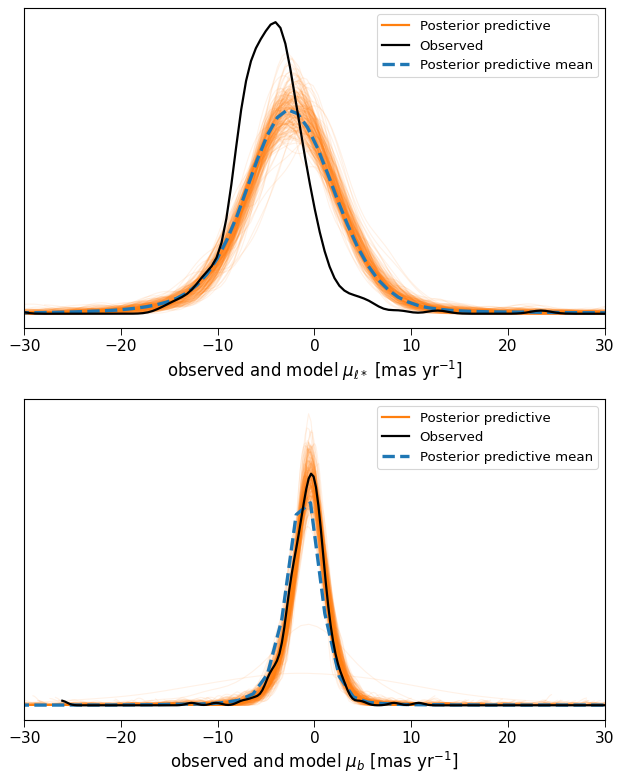

In [54]:
fig, axes = plt.subplots(2, 1, figsize=(8, 2*5), tight_layout=True)
az.plot_ppc(idata, ax=axes, data_pairs={'pml_obs':'pred_pml', 'pmb_obs':'pred_pmb'}, 
            num_pp_samples=200, alpha=0.1, colors=['C1', 'k', 'C0'])
for ax in axes:
    ax.legend(fontsize=12)
    #apply_tufte(ax)
axes[0].set_xlim(-30,30)
axes[1].set_xlim(-30,30)
axes[0].set_xlabel(r'observed and model $\mu_{\ell*}$ [mas yr$^{-1}$]')
axes[1].set_xlabel(r'observed and model $\mu_b$ [mas yr$^{-1}$]')

plt.savefig('fgkmstars_pms_posterior_predictive.png')

plt.show()

       R_gc       
        pc        
------------------
 9044.336714403385
 6084.892915559331
 8011.091930229086
 7251.069472913693
5608.8722001693495
 6028.503652700872
 7790.049857353888
 6509.682053825645
 6742.841700977004
 5979.715067908311
               ...
 8941.830951759248
 8234.419965921354
 6591.646723427859
 9389.134972017277
  6434.81001322367
6630.6142669763385
7424.1866305087915
 6795.277438743635
 5618.038857256095
7785.1612528371525
Length = 300 rows


(0.0, 300.89831596978604)

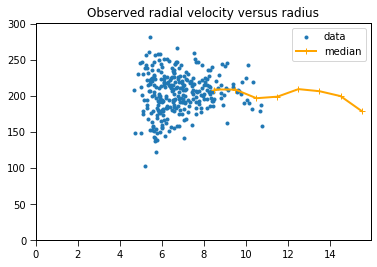

In [12]:
pml_obs = np.array(fgkm_subsample['pml'].tolist())
pmb_obs = fgkm_subsample['pmb'].tolist()
galat = np.deg2rad(fgkm_subsample['b']).tolist()
galon = np.deg2rad(fgkm_subsample['l']).tolist()
rvec = np.zeros((len(galat), 3))
Rsun_raw = 8277.0

plx = fgkm_subsample['parallax'].tolist()
starpos = np.zeros((len(galat), 3))
Rstars = np.zeros(len(galat))

# for n in range(len(galat)):
#     rvec[n][0] = np.cos(galat[n])*np.cos(galon[n])
#     rvec[n][1] = np.cos(galat[n])*np.sin(galon[n])
#     rvec[n][2] = np.sin(galat[n])
# #     print(rvec)
#     for j in range(3):
#         starpos[n] = (1.0/plx[n])*rvec[n] + (-Rsun_raw/1000.0)   # -Rsun used to be sunpos (but Zsun = 0 and Ysun = 0).
#     Rstars[n] = np.sqrt(starpos[n][0]**2+starpos[n][1]**2)
v_phi = fgkm_subsample['v_phi_gc']

bins = np.linspace(0, 20, 21)
bin_mids = np.zeros(len(bins)-1)
bins_filled = np.zeros(len(bins)-1, dtype=np.ndarray)
bins_mean = np.zeros(len(bins)-1)
empty_dropper = np.zeros(len(bins_filled), dtype=bool)
for i in range(len(bins)-1):
    bin_mids[i] = bins[i]+(bins[i+1]-bins[i])/2
    bins_temp = []
    for star_index in range(len(Rstars)):
        if (not Rstars[star_index] < bins[i]) & (Rstars[star_index] < bins[i+1]):
            
            # Removing some nan values
            if not np.isnan(float(v_phi[star_index])):
                bins_temp.append(v_phi[star_index])
    bins_filled[i] = np.array(bins_temp)
    bins_mean[i] = np.mean(bins_filled[i])

    if len(bins_filled[i]) == 0:
        empty_dropper[i] = False
    else:
        empty_dropper[i] = True
    

bin_mids = bin_mids[empty_dropper]
bins_filled = bins_filled[empty_dropper]
bins_mean = bins_mean[empty_dropper]

print(fgkm_subsample['R_gc'])
plt.scatter(fgkm_subsample['R_gc']/1000, v_phi, marker='.', label='data')
plt.plot(bin_mids, bins_mean, marker='+', color='orange', label='mean')
plt.title("Observed radial velocity versus radius")
plt.legend()
plt.xlim(0, np.max(Rstars)+0.5)
plt.ylim(0,np.max(v_phi)+20)

([-1.0079750208565872, -2.531342894725077, -5.715245696949326, -32.55711464906418, -3.032465875774105, -3.6275003101617243, -0.6571702991949189, -7.447424047439742, -4.9779957848187495, -3.719931135487529, -2.7800376887159173, -6.3224378574716615, -5.909335297640844, -3.174796498169515, 2.9060811058852196, -3.6705892599273438, -4.507939428111727, 12.782842402691639, -3.4040949735879433, -1.2656252551352678, -3.231188169315926, -7.331984735721958, -6.319887198521742, -1.2705694204889568, 5.509580983899461, -2.0737211559055586, -7.510250463124198, -8.221311496626297, -1.980692324430636, -0.5042169003152214, -6.140139074036982, -7.682351286376446, -8.76258117093234, -4.561144318588569, -8.891468789349334, -31.57671899044354, -6.679974467097087, -7.7850809244274295, 0.9630732708862777, -11.691569412017275, -6.502622161833334, -3.4631925535029224, -3.0318854735220735, -0.4833325136191977, -7.611327430699251, -7.823454029978029, -3.3601760687646385, -3.357693099539561, -2.8745738108175862, -

<ipython-input-133-853cc4825df1>:38: UserWarning: Warning: converting a masked element to nan.
  if not np.isnan(float(radial_velocity[star_index])):
<ipython-input-133-853cc4825df1>:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  vdiff = np.array([-radial_velocity*np.sin(phi), radial_velocity*np.cos(phi), 0.0])# - np.array([0.0, 234.0, 0.0]) #+ [Vsun_pec_x, Vsun_pec_y, Vsun_pec_z])


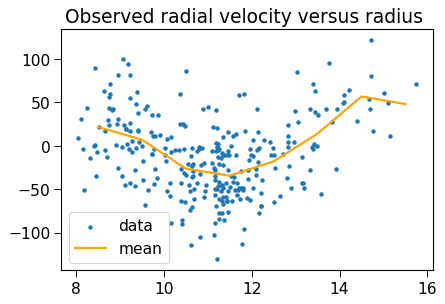

In [133]:
# galat = np.deg2rad(fgkm_subsample['b']).tolist()
# galon = np.deg2rad(fgkm_subsample['l']).tolist()
# rvec = np.zeros((len(galat), 3))
# Rsun_raw = 8277.0

# plx = fgkm_subsample['parallax'].tolist()
# starpos = np.zeros((len(galat), 3))
# Rstars = np.zeros(len(galat))

# for n in range(len(galat)):
#     rvec[n][0] = np.cos(galat[n])*np.cos(galon[n])
#     rvec[n][1] = np.cos(galat[n])*np.sin(galon[n])
#     rvec[n][2] = np.sin(galat[n])
# #     print(rvec)
#     starpos[n] = (1.0/plx[n])*rvec[n] + (-Rsun_raw/1000.0)   # -Rsun used to be sunpos (but Zsun = 0 and Ysun = 0).
#     Rstars[n] = np.sqrt(starpos[n][0]**2+starpos[n][1]**2)


# # print(Rstars)
# sorted_indices = np.argsort(Rstars)

# radial_velocity = fgkm_subsample['radial_velocity']
# plt.scatter(Rstars, radial_velocity, marker='.', label="data")

# # plt.figure()
# bins = np.linspace(0, 20, 21)
# bin_mids = np.zeros(len(bins)-1)
# bins_filled = np.zeros(len(bins)-1, dtype=np.ndarray)
# bins_mean = np.zeros(len(bins)-1)
# empty_dropper = np.zeros(len(bins_filled), dtype=bool)
# for i in range(len(bins)-1):
#     bin_mids[i] = bins[i]+(bins[i+1]-bins[i])/2
#     bins_temp = []
#     for star_index in range(len(Rstars)):
#         if (not Rstars[star_index] < bins[i]) & (Rstars[star_index] < bins[i+1]):
            
#             # Removing some nan values
#             if not np.isnan(float(radial_velocity[star_index])):
#                 bins_temp.append(radial_velocity[star_index])
#     bins_filled[i] = np.array(bins_temp)
#     bins_mean[i] = np.mean(bins_filled[i])

#     if len(bins_filled[i]) == 0:
#         empty_dropper[i] = False
#     else:
#         empty_dropper[i] = True
    

# bin_mids = bin_mids[empty_dropper]
# bins_filled = bins_filled[empty_dropper]
# bins_mean = bins_mean[empty_dropper]

# phi = np.arctan2(starpos[:,1], starpos[:,0])
# vx = -radial_velocity*np.sin(phi)
# vy = radial_velocity*np.cos(phi)
# vdiff = np.array([-radial_velocity*np.sin(phi), radial_velocity*np.cos(phi), 0.0])# - np.array([0.0, 234.0, 0.0]) #+ [Vsun_pec_x, Vsun_pec_y, Vsun_pec_z])
# # v_abs = np.sqrt(vdiff[0]**2+vdiff[1]**2)

# plt.plot(bin_mids, bins_mean, c='orange', label="mean")
# plt.legend()
# plt.title("Observed radial velocity versus radius ")

# pml_obs = fgkm_subsample['pml'].tolist(),
# pmb_obs = fgkm_subsample['pmb'].tolist(),

# print(pml_obs)

                
# # Radial velocity is snelheid is line of sight (naar je toe of van je af en neemt zijwaards niet mee)

<ipython-input-176-757fb66fd354>:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  vdiff = np.array([-rad_velocity*np.sin(phi), rad_velocity*np.cos(phi), 0.0])# - np.array([0.0, 234.0, 0.0]) #+ [Vsun_pec_x, Vsun_pec_y, Vsun_pec_z])


Text(0, 0.5, '$\\mu_{\\ell*}$ [mas yr$^{-1}$]')

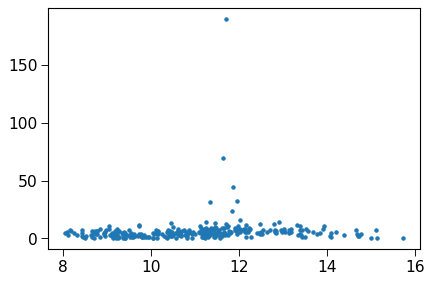

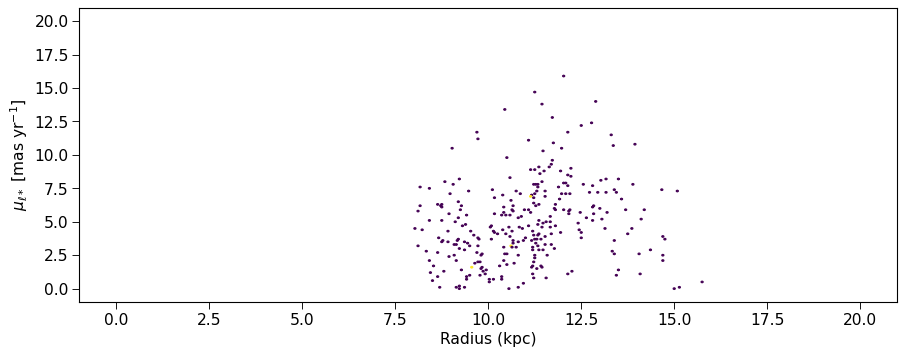

In [176]:
pml_obs = np.array(fgkm_subsample['pml'].tolist())
pmb_obs = fgkm_subsample['pmb'].tolist()
galat = np.deg2rad(fgkm_subsample['b']).tolist()
galon = np.deg2rad(fgkm_subsample['l']).tolist()
rvec = np.zeros((len(galat), 3))
Rsun_raw = 8277.0

plx = fgkm_subsample['parallax'].tolist()
starpos = np.zeros((len(galat), 3))
Rstars = np.zeros(len(galat))

for n in range(len(galat)):
    rvec[n][0] = np.cos(galat[n])*np.cos(galon[n])
    rvec[n][1] = np.cos(galat[n])*np.sin(galon[n])
    rvec[n][2] = np.sin(galat[n])
#     print(rvec)
    starpos[n] = (1.0/plx[n])*rvec[n] + (-Rsun_raw/1000.0)   # -Rsun used to be sunpos (but Zsun = 0 and Ysun = 0).
    Rstars[n] = np.sqrt(starpos[n][0]**2+starpos[n][1]**2)


# print(Rstars)
sorted_indices = np.argsort(Rstars)

rad_velocity = np.abs(pml_obs)
plt.scatter(Rstars, np.abs(rad_velocity), marker='.', label="data")

# plt.figure()
bins = np.linspace(0, 20, 21)
bin_mids = np.zeros(len(bins)-1)
bins_filled = np.zeros(len(bins)-1, dtype=np.ndarray)
bins_mean = np.zeros(len(bins)-1)
empty_dropper = np.zeros(len(bins_filled), dtype=bool)
for i in range(len(bins)-1):
    bin_mids[i] = bins[i]+(bins[i+1]-bins[i])/2
    bins_temp = []
    for star_index in range(len(Rstars)):
        if (not Rstars[star_index] < bins[i]) & (Rstars[star_index] < bins[i+1]):
            
            # Removing some nan values
            if not np.isnan(float(rad_velocity[star_index])):
                bins_temp.append(rad_velocity[star_index])
    bins_filled[i] = np.array(bins_temp)
    bins_mean[i] = np.mean(bins_filled[i])

    if len(bins_filled[i]) == 0:
        empty_dropper[i] = False
    else:
        empty_dropper[i] = True
    

bin_mids = bin_mids[empty_dropper]
bins_filled = bins_filled[empty_dropper]
bins_mean = bins_mean[empty_dropper]

phi = np.arctan2(starpos[:,1], starpos[:,0])
vx = -rad_velocity*np.sin(phi)
vy = rad_velocity*np.cos(phi)
vdiff = np.array([-rad_velocity*np.sin(phi), rad_velocity*np.cos(phi), 0.0])# - np.array([0.0, 234.0, 0.0]) #+ [Vsun_pec_x, Vsun_pec_y, Vsun_pec_z])
v_abs = np.sqrt(vdiff[0]**2+vdiff[1]**2)

# plt.plot(bin_mids, bins_mean, c='orange', label="mean")
# plt.legend()
# plt.title("Observed rad velocity versus radius ")

fig=plt.figure(constrained_layout=True, figsize=(0.8*14,0.8*10))

gs = GridSpec(2, 1, figure=fig)

ax_lmul = fig.add_subplot(gs[0,0])
im_lmul = ax_lmul.hexbin(Rstars, v_abs, 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,20,-0,20])
ax_lmul.set_xlabel(r'Radius (kpc)')
ax_lmul.set_ylabel(r'$\mu_{\ell*}$ [mas yr$^{-1}$]')
# ax_lmul.set_xlim(0,20)

# print(pml_obs)

                
# rad velocity is snelheid is line of sight (naar je toe of van je af en neemt zijwaards niet mee)

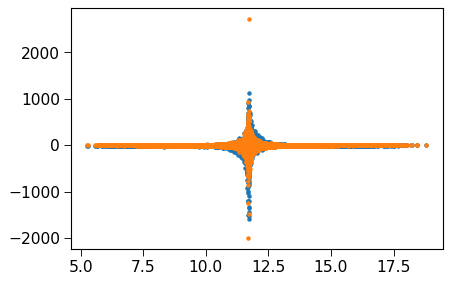

In [146]:
pml_obs = np.array(fgkmtable['pml'].tolist())
pmb_obs = fgkmtable['pmb'].tolist()
galat = np.deg2rad(fgkmtable['b']).tolist()
galon = np.deg2rad(fgkmtable['l']).tolist()
rvec = np.zeros((len(galat), 3))
Rsun_raw = 8277.0

plx = fgkmtable['parallax'].tolist()
starpos = np.zeros((len(galat), 3))
Rstars = np.zeros(len(galat))

for n in range(len(galat)):
    rvec[n][0] = np.cos(galat[n])*np.cos(galon[n])
    rvec[n][1] = np.cos(galat[n])*np.sin(galon[n])
    rvec[n][2] = np.sin(galat[n])
#     print(rvec)
    starpos[n] = (1.0/plx[n])*rvec[n] + (-Rsun_raw/1000.0)   # -Rsun used to be sunpos (but Zsun = 0 and Ysun = 0).
    Rstars[n] = np.sqrt(starpos[n][0]**2+starpos[n][1]**2)
    
plt.scatter(Rstars, pml_obs, marker='.')
plt.scatter(Rstars, pmb_obs, marker='.')

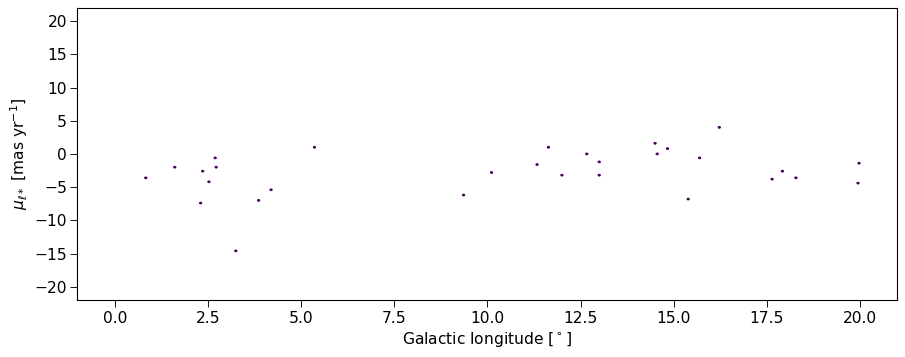

In [187]:
fig=plt.figure(constrained_layout=True, figsize=(0.8*14,0.8*10))

gs = GridSpec(2, 1, figure=fig)

ax_lmul = fig.add_subplot(gs[0,0])
im_lmul = ax_lmul.hexbin(fgkm_subsample['l'], fgkm_subsample['pml'], 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,20,-20,20])
ax_lmul.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmul.set_ylabel(r'$\mu_{\ell*}$ [mas yr$^{-1}$]')
# ax_lmul.set_xlim(0,360)

# ax_lmub = fig.add_subplot(gs[1,0])
# im_lmub = ax_lmub.hexbin(obatable['l'][sample_filter], obatable['pmb'][sample_filter], 
#                          gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
# ax_lmub.set_xlabel(r'Galactic longitude [$^\circ$]')
# ax_lmub.set_ylabel(r'$\mu_b$ [mas yr$^{-1}$]')
# ax_lmub.set_xlim(0,360)

plt.show()

In [197]:
pvec = np.zeros((len(galat), 3))
v_phi = np.zeros((len(galat), 3))
for n in range(len(galat)):
    pvec[n][0] = -np.sin(galon[n])
    pvec[n][1] = np.cos(galon[n])
    pvec[n][2] = 0.0
#     print(rvec)
    starpos[n] = (1.0/plx[n])*rvec[n] + (-Rsun_raw/1000.0)   # -Rsun used to be sunpos (but Zsun = 0 and Ysun = 0).
    Rstars[n] = np.sqrt(starpos[n][0]**2+starpos[n][1]**2)

    v_phi[n] = (pml_obs[n]/(np.dot(plx[n], pvec[n])) - [0, 234.0, 0])
    print(v_phi)
        
print(np.size(Rstars))
print(np.size(v_phi))
plt.scatter(Rstars, v_phi)

<ipython-input-197-96e1dee43e55>:11: RuntimeWarning: divide by zero encountered in true_divide
  v_phi[n] = (pml_obs[n]/(np.dot(plx[n], pvec[n])) - [0, 234.0, 0])


[[-127.9025028 -237.2133503         -inf]
 [   0.           0.           0.       ]
 [   0.           0.           0.       ]
 [   0.           0.           0.       ]
 [   0.           0.           0.       ]
 [   0.           0.           0.       ]
 [   0.           0.           0.       ]
 [   0.           0.           0.       ]
 [   0.           0.           0.       ]
 [   0.           0.           0.       ]
 [   0.           0.           0.       ]
 [   0.           0.           0.       ]
 [   0.           0.           0.       ]
 [   0.           0.           0.       ]
 [   0.           0.           0.       ]
 [   0.           0.           0.       ]
 [   0.           0.           0.       ]
 [   0.           0.           0.       ]
 [   0.           0.           0.       ]
 [   0.           0.           0.       ]
 [   0.           0.           0.       ]
 [   0.           0.           0.       ]
 [   0.           0.           0.       ]
 [   0.           0.           0. 

[[-127.9025028  -237.2133503           -inf]
 [   8.51824325 -244.63216609          -inf]
 [ -82.07926998 -250.16203614          -inf]
 [ -12.2245862  -626.29991401          -inf]
 [ -15.23948151 -245.99765082          -inf]
 [  25.28296041 -245.05935894          -inf]
 [  -9.55056424 -236.18048126          -inf]
 [ 433.70871765 -251.44328442          -inf]
 [  19.02877189 -251.8203166           -inf]
 [  17.08318139 -127.37497696          -inf]
 [  14.87120752 -246.32469593          -inf]
 [ -36.03556882 -261.85232416          -inf]
 [  20.38596252 -255.04585976          -inf]
 [  38.18563924 -242.82428446          -inf]
 [  26.31911119 -242.98228863           inf]
 [ -22.69744326 -247.18022634          -inf]
 [  22.71217678 -258.28242693          -inf]
 [ -10.39610754 -244.73527809           inf]
 [ -13.23547392 -237.31262542          -inf]
 [  12.64279143 -236.91528723          -inf]
 [ -33.66963367 -244.68286055          -inf]
 [ -35.343742   -510.4085119           -inf]
 [  44.812

[[-1.27902503e+02 -2.37213350e+02            -inf]
 [ 8.51824325e+00 -2.44632166e+02            -inf]
 [-8.20792700e+01 -2.50162036e+02            -inf]
 [-1.22245862e+01 -6.26299914e+02            -inf]
 [-1.52394815e+01 -2.45997651e+02            -inf]
 [ 2.52829604e+01 -2.45059359e+02            -inf]
 [-9.55056424e+00 -2.36180481e+02            -inf]
 [ 4.33708718e+02 -2.51443284e+02            -inf]
 [ 1.90287719e+01 -2.51820317e+02            -inf]
 [ 1.70831814e+01 -1.27374977e+02            -inf]
 [ 1.48712075e+01 -2.46324696e+02            -inf]
 [-3.60355688e+01 -2.61852324e+02            -inf]
 [ 2.03859625e+01 -2.55045860e+02            -inf]
 [ 3.81856392e+01 -2.42824284e+02            -inf]
 [ 2.63191112e+01 -2.42982289e+02             inf]
 [-2.26974433e+01 -2.47180226e+02            -inf]
 [ 2.27121768e+01 -2.58282427e+02            -inf]
 [-1.03961075e+01 -2.44735278e+02             inf]
 [-1.32354739e+01 -2.37312625e+02            -inf]
 [ 1.26427914e+01 -2.36915287e+

[[-1.27902503e+02 -2.37213350e+02            -inf]
 [ 8.51824325e+00 -2.44632166e+02            -inf]
 [-8.20792700e+01 -2.50162036e+02            -inf]
 [-1.22245862e+01 -6.26299914e+02            -inf]
 [-1.52394815e+01 -2.45997651e+02            -inf]
 [ 2.52829604e+01 -2.45059359e+02            -inf]
 [-9.55056424e+00 -2.36180481e+02            -inf]
 [ 4.33708718e+02 -2.51443284e+02            -inf]
 [ 1.90287719e+01 -2.51820317e+02            -inf]
 [ 1.70831814e+01 -1.27374977e+02            -inf]
 [ 1.48712075e+01 -2.46324696e+02            -inf]
 [-3.60355688e+01 -2.61852324e+02            -inf]
 [ 2.03859625e+01 -2.55045860e+02            -inf]
 [ 3.81856392e+01 -2.42824284e+02            -inf]
 [ 2.63191112e+01 -2.42982289e+02             inf]
 [-2.26974433e+01 -2.47180226e+02            -inf]
 [ 2.27121768e+01 -2.58282427e+02            -inf]
 [-1.03961075e+01 -2.44735278e+02             inf]
 [-1.32354739e+01 -2.37312625e+02            -inf]
 [ 1.26427914e+01 -2.36915287e+

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [199]:
print(fgkm_subsample['v_phi_gc'])

     v_phi_gc     
      km / s      
------------------
 216.0873115494033
  170.361190337899
182.07823690288274
235.77962965031026
217.07149940189757
190.34120359477595
198.89386297000192
 149.0617956478303
214.83830618411838
223.54941050719782
               ...
 215.6494246013061
217.98516871887153
219.94242654187164
213.35792080053773
244.35770534836058
 193.8958834031217
 171.4290433776566
206.64495076642788
201.00120420875157
 235.1237523919159
Length = 300 rows


In [42]:
import winsound
frequency = 1000
duration = 2000  # 1000 ms = 1 second
winsound.Beep(frequency, duration)

# Now small test without v0

In [53]:
# Reading in earlier produced fits
filter_dictionary = {
                  'no_spt_filter':no_spt_filter,
                  'giants':giants,
                  'fstars':fstars,
                  'gstars':gstars,
                  'kstars':kstars,
                  'mstars':mstars,
                 }
# Choice of stars
filter_of_choice = "giants"

spt_lum_filter = filter_dictionary[filter_of_choice]
fit_save_location = os.path.join(os.getcwd(), 'fitfiles', filter_of_choice, "Backup")

test_fit = from_csv(path=fit_save_location)
print(fit_save_location[-len(filter_of_choice):])

13:32:01 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 3 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.


Backup


In [54]:
# I have removed chain 4 (34.8% iterations at max treedepth).
print(fit_save_location)
test_fit.summary()[0:stan_model['npars']+6]
# Made by using the 3 converged fit files.
# Without v0

C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\fitfiles\giants\Backup


Mean          MCSE        StdDev            5%  \
lp__          -8.423090e+07  4.864640e+07  5.967140e+07 -1.310580e+08   
h_param        1.137230e+00  1.100980e+00  1.351250e+00  1.579230e-02   
p_param       -1.197630e+00  6.541120e-01  9.039700e-01 -3.074760e+00   
Vsun_pec_x     5.993160e+00  7.397790e+00  9.113630e+00 -6.447780e-01   
Vsun_pec_y     7.920830e+00  8.704210e+00  1.068250e+01 -8.106280e-01   
Vsun_pec_z     3.417020e+00  3.181130e+00  3.902630e+00 -3.182650e-02   
amplitude_x    4.417380e+01  4.959090e+01  6.086760e+01  4.755170e-01   
amplitude_y    1.656420e+01  1.741180e+01  2.153790e+01  2.194700e-01   
amplitude_z    4.686440e+00  4.574880e+00  5.615690e+00  2.341500e-01   
R_scale_x      6.606070e+00  6.946180e+00  8.546790e+00  1.408060e-01   
R_scale_y      5.360610e+00  3.307500e+00  4.069210e+00  1.411610e-01   
R_scale_z      7.579810e+00  6.459480e+00  7.953970e+00  1.346660e+00   
model_pm[1,1] -1.508040e+00  2.514470e-01  3.101290e-01 -1.773480e+00   
model_pm[1,2] -2.783990e-01  2.373070e-01  2.911330e-01 -6.975610e-01   
model_pm[2,1] -1.767330e+00  2.691970e-01  3.320730e-01 -2.054930e+00   
model_pm[2,2] -2.850440e-01  2.592450e-01  3.180430e-01 -7.421030e-01   
model_pm[3,1] -2.313480e+00  7.354800e-02  9.593690e-02 -2.430230e+00   

                        50%          95%    N_Eff   N_Eff/s      R_hat  
lp__          -1.220220e+08 -5671.720000  1.50463  0.000712  207.96400  
h_param        2.728990e-01     3.043730  1.50631  0.000713   26.47650  
p_param       -7.258570e-01    -0.578569  1.90987  0.000904    2.04620  
Vsun_pec_x    -2.884410e-01    20.701700  1.51767  0.000719    9.84227  
Vsun_pec_y     1.689490e+00    23.743100  1.50622  0.000713   27.29400  
Vsun_pec_z     1.433440e+00     9.026840  1.50506  0.000713   48.43420  
amplitude_x    1.893570e+00   134.788000  1.50650  0.000713   25.40720  
amplitude_y    2.837010e+00    52.194600  1.53011  0.000725    7.11683  
amplitude_z    1.207290e+00    13.081800  1.50677  0.000713   23.76070  
R_scale_x      1.063580e+00    20.015900  1.51396  0.000717   11.66170  
R_scale_y      5.878370e+00    10.263200  1.51363  0.000717   12.18470  
R_scale_z      2.782370e+00    20.146800  1.51626  0.000718   10.49570  
model_pm[1,1] -1.670470e+00    -1.005700  1.52121  0.000720    8.72575  
model_pm[1,2] -1.262380e-01    -0.024699  1.50508  0.000713   47.68380  
model_pm[2,1] -1.937130e+00    -1.228040  1.52170  0.000721    8.60536  
model_pm[2,2] -1.219620e-01    -0.005200  1.50505  0.000713   48.84680  
model_pm[3,1] -2.293390e+00    -2.147980  1.70149  0.000806    2.72567

In [17]:
# data Rsun
# real Vcirc_sun = Rsun/h_param * (1 + (Rsun/h_param)^2) ^ ((p_param-2)/4);
# This is only the scaling factor. What is v_0?
Rsun_float = float(Rsun/(1*u.pc)) # in pc
print(Rsun_float)
h_param = 0.14
p_param = 0.370 # in pc
# v_0 = 
vcsun_data = 234.0
Vcircsun = Rsun_float/h_param * (1 + (Rsun_float/h_param)**2) ** ((p_param-2)/4)
v0 = vcsun_data/Vcircsun
vc = v0*Vcircsun

print("Vcircsun:", Vcircsun*u.pc/(u.s))
Vcircsun_with_units = Vcircsun*u.pc/u.s
print("Vcircsun:", Vcircsun_with_units.to(u.km/u.s))
print(v0)
print(vc)

8277.0
Vcircsun: 7.6343630711626504 pc / s
Vcircsun: 235571829776521.75 km / s
30.65088702473299
234.0


In [11]:
fgkm_fit.diagnose()

"Processing csv files: C:\\Users\\rjrri\\Documents\\Universiteit\\First project\\milkyway-rotation-curve_fork\\fitfiles\\giants\\rotcurve-bp2_3_giants_std_nov0-20230403113246_1.csv, C:\\Users\\rjrri\\Documents\\Universiteit\\First project\\milkyway-rotation-curve_fork\\fitfiles\\giants\\rotcurve-bp2_3_giants_std_nov0-20230403113246_2.csv, C:\\Users\\rjrri\\Documents\\Universiteit\\First project\\milkyway-rotation-curve_fork\\fitfiles\\giants\\rotcurve-bp2_3_giants_std_nov0-20230403113246_3.csv, C:\\Users\\rjrri\\Documents\\Universiteit\\First project\\milkyway-rotation-curve_fork\\fitfiles\\giants\\rotcurve-bp2_3_giants_std_nov0-20230403113246_4.csv\n\nChecking sampler transitions treedepth.\n348 of 4000 (8.70%) transitions hit the maximum treedepth limit of 10, or 2^10 leapfrog steps.\nTrajectories that are prematurely terminated due to this limit will result in slow exploration.\nFor optimal performance, increase this limit.\n\nChecking sampler transitions for divergences.\n1 of 4000

['h_param', 'p_param', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'amplitude_x', 'amplitude_y', 'amplitude_z', 'R_scale_x', 'R_scale_y', 'R_scale_z']
h_param = 0.1+6.9-0.1
p_param = -1.7+3.3-1.1
Vsun_pec_x = 19.3+2.3-21.1
Vsun_pec_y = 23.0+0.8-24.9
Vsun_pec_z = 9.0+0.2-6.9
amplitude_x = 124.1+5.9-124.0
amplitude_y = 49.0+6.6-3.5
amplitude_z = 14.2+0.8-13.8
R_scale_x = 18.2+2.0-18.1
R_scale_y = 5.3+44.6-0.6
R_scale_z = 16.4+1.9-15.8


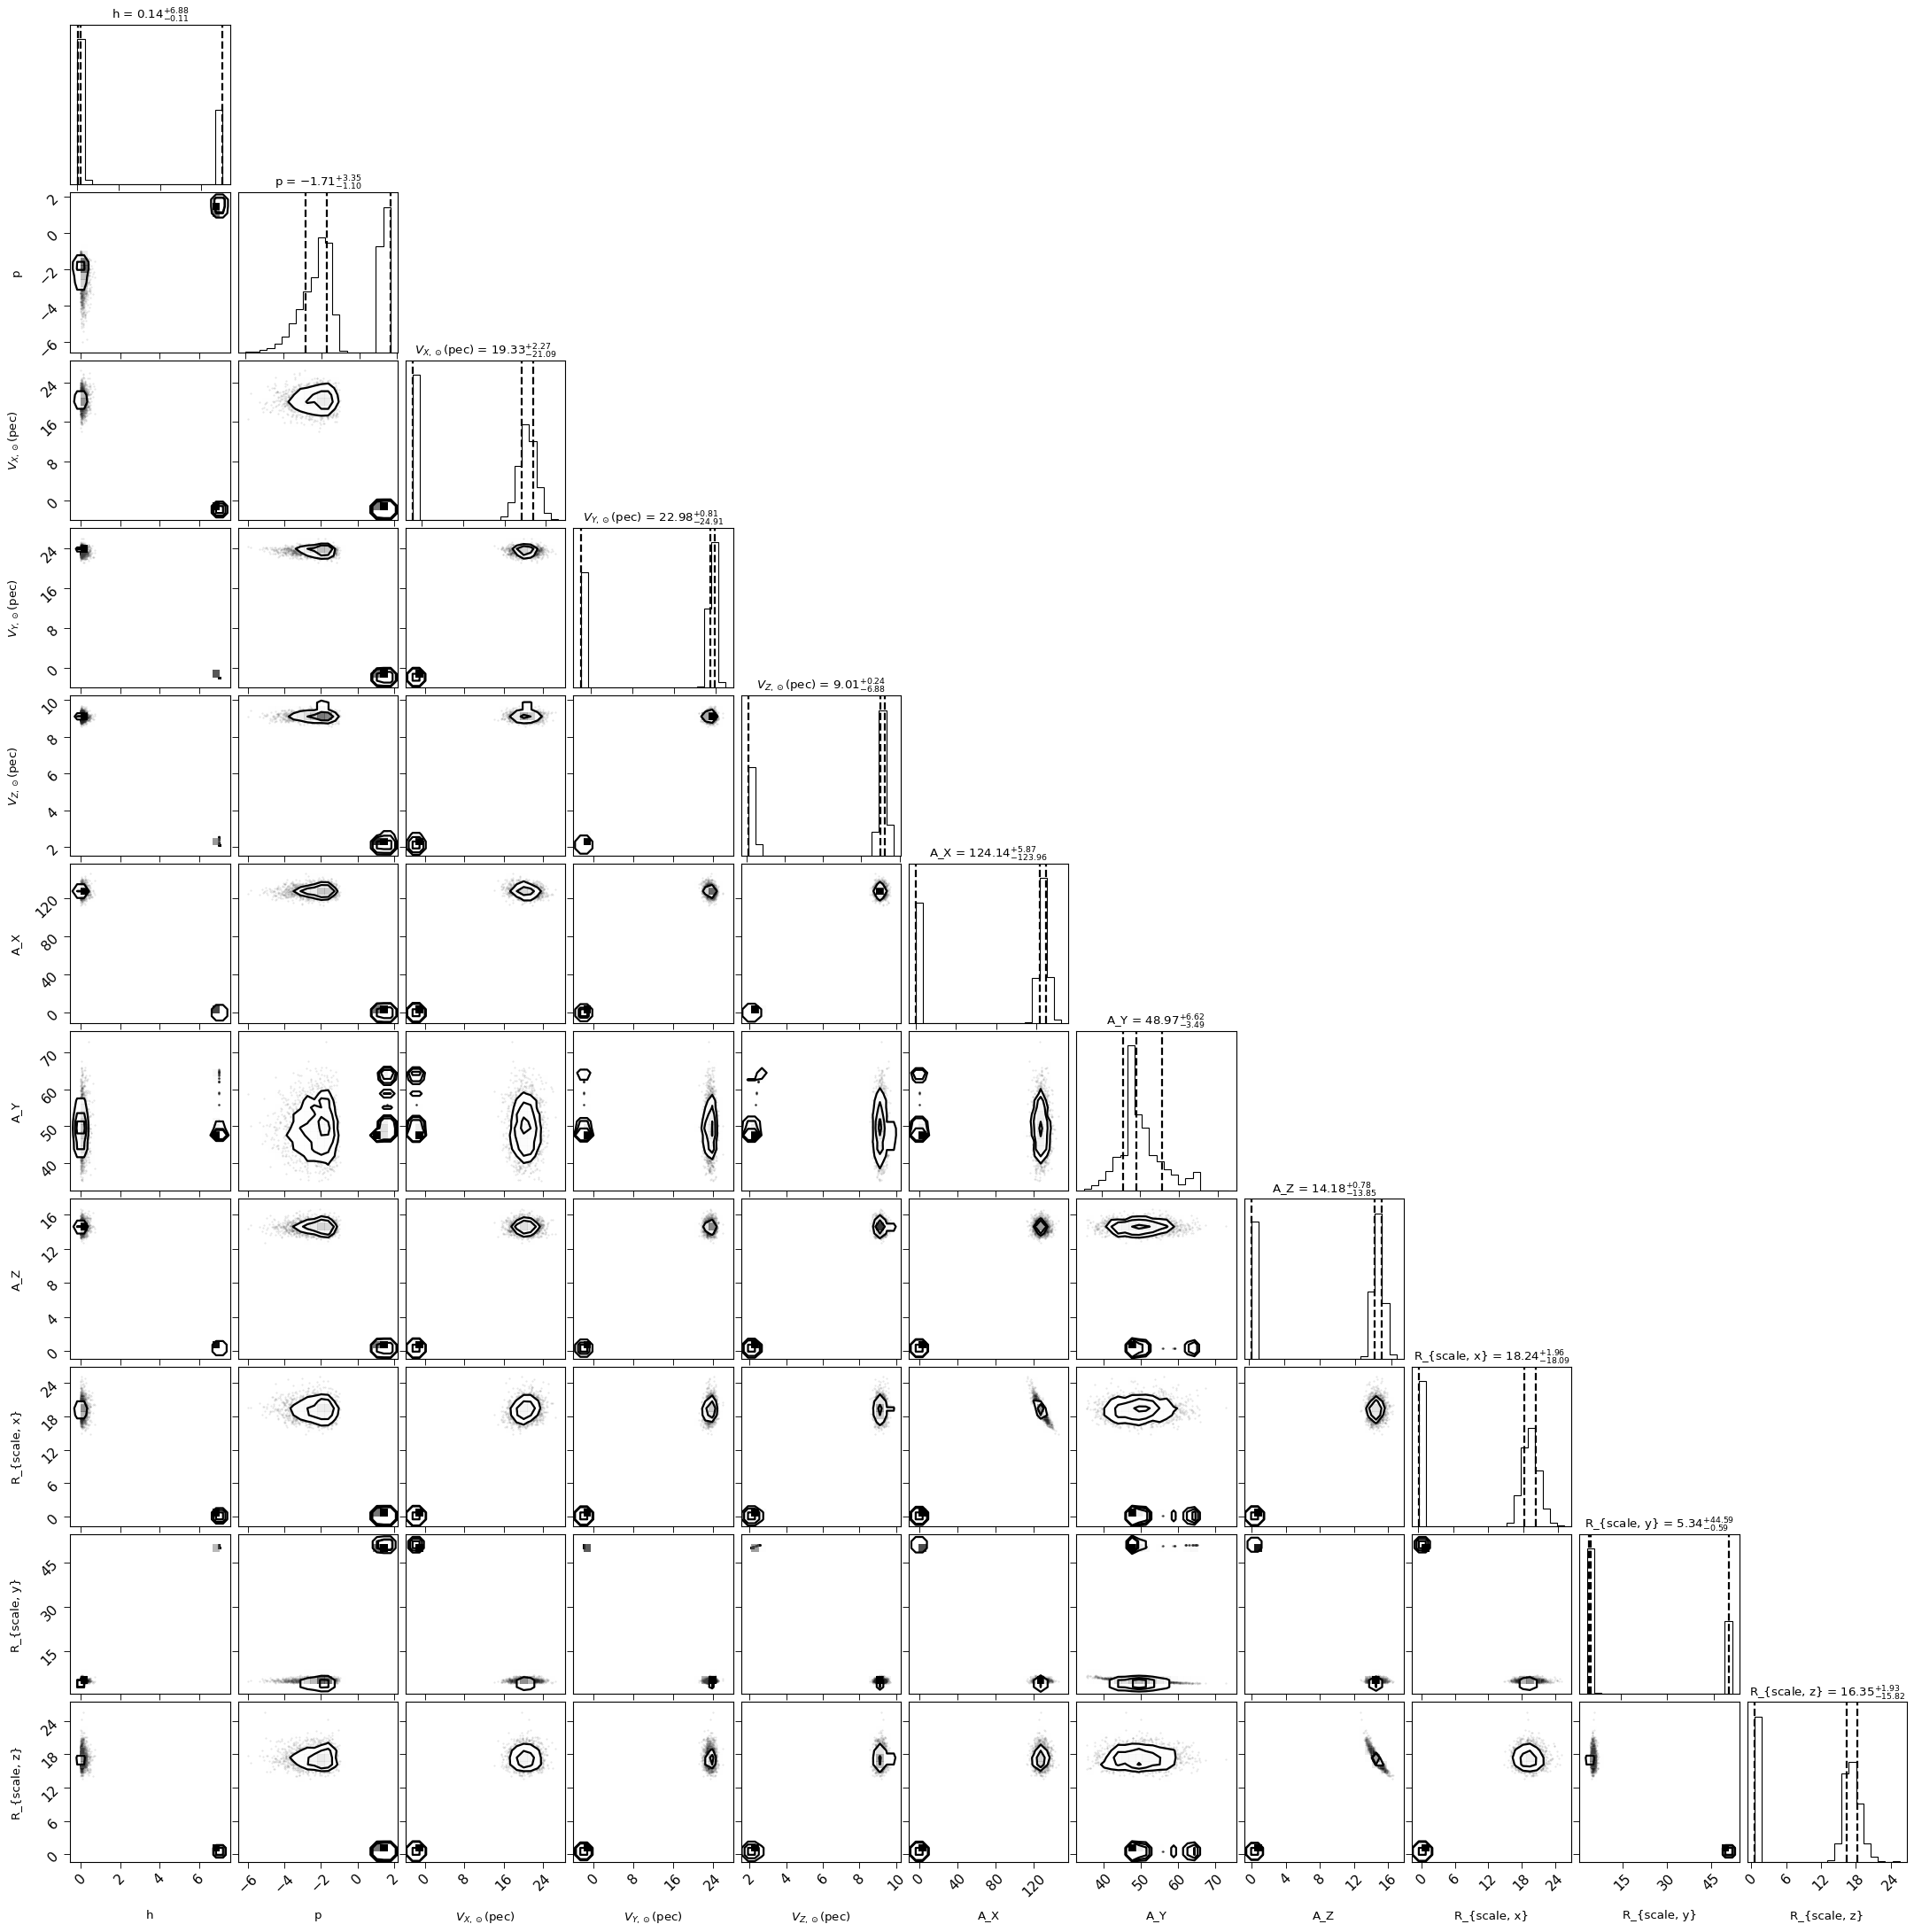

{'h_param': 0.1393325, 'p_param': -1.71083, 'Vsun_pec_x': 19.32865, 'Vsun_pec_y': 22.983249999999998, 'Vsun_pec_z': 9.00809, 'amplitude_x': 124.144, 'amplitude_y': 48.9658, 'amplitude_z': 14.1759, 'R_scale_x': 18.23955, 'R_scale_y': 5.343145, 'R_scale_z': 16.352249999999998}
11
[array([0.141089 , 7.04952  , 0.0241228, ..., 0.0725808, 7.00303  ,
       0.0493147]), array([-1.52285 ,  0.966082, -2.55496 , ..., -1.44851 ,  1.64055 ,
       -2.07593 ]), array([20.0601 , -1.76492, 20.1134 , ..., 19.3956 , -1.75336, 19.6092 ]), array([23.087  , -1.92401, 22.4021 , ..., 23.0117 , -1.92384, 23.6726 ]), array([8.87872, 2.10928, 9.1052 , ..., 8.89957, 2.5648 , 9.10016]), array([132.39    ,   0.180942, 129.383   , ..., 139.711   ,   0.180765,
       120.843   ]), array([50.9275, 46.9551, 49.4658, ..., 50.3008, 65.3359, 48.2355]), array([14.4797  ,  0.328309, 15.0121  , ..., 13.8372  ,  0.328625,
       14.5227  ]), array([18.401   ,  0.152424, 19.1088  , ..., 15.7369  ,  0.152392,
       21.4477 

In [55]:
print(stan_model['parnames'])
for par in stan_model['parnames']:
    vals = fgkm_fit.stan_variable(par)
    stan_model['best_params'][par] = np.median(vals)
    q1, q2, q3 = scap(vals, [16, 50, 84])
    print(f"{par} = {q2:.1f}+{q3-q2:.1f}-{q2-q1:.1f}")

sample_lists = []
for i, par in zip(range(7, 7+stan_model['npars']), stan_model['parnames']): # Adjusted the number from 9 to 2 (# of parameters)
    sample_lists.append(fgkm_fit.draws()[:,:,i].flatten())
samples = np.vstack(sample_lists).transpose()

useagab(usetex=False, fontfam='sans-serif', fontsize=14, ncolors=10)

figcorner = plt.figure(figsize=(2.5*stan_model['npars'],2.5*stan_model['npars']))
corner.corner(
    samples, labels=stan_model['labels'], 
    label_kwargs={"fontsize":12}, title_kwargs={"fontsize": 12},
    truth_color='r', quantiles=[0.16,0.50,0.84], show_titles=True, fig=figcorner
)
plt.show()

# Number of draws is very low
print(stan_model['best_params'])
print(len(sample_lists))
print(sample_lists)
print(samples)
print(len(samples)) # 4000 samples
# Dit was gecreerd met een subsample van 10000 ipv 3000.